In [23]:
from scipy.io import loadmat
import numpy as np
import torch 
from torch.utils.data import random_split, DataLoader
from mrnn7 import MilliesDataset, MilliesRNN
from math import ceil
from torch import nn
import torch.nn.utils.prune as prune
from hessianfree import HessianFree
import matplotlib.pyplot as plt

In [19]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)

    loss = torch.sum((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [20]:
muscle_length_vec = torch.tensor([9.8, 10.8, 13.7, 6.8, 7.6, 8.7, 7.4, 16.2, 14.4, 13.8, 13.8, 25.4, 23.2, 27.9, 9.3, 13.4, 11.4, 11.4, 2.7, 3.3, 11.6, 13.2, 8.6, 17.3, 8.1, 5.9, 6.2, 6.3, 5.1, 6.4, 4.9, 2.8, 5.2, 7.4, 7.5, 8.4, 7.5, 8.0, 8.4, 7.5, 6.5, 6.3, 7.2, 7.0, 6.8, 5.9, 5.4, 6.8, 5.5, 7.1])
muscle_weight_vec = (1/muscle_length_vec) * (2.5*torch.min(muscle_length_vec))

def hardcore_loss_weighted(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)
    
    target_diff_sum = torch.sum((muscle_weight_vec*(output - target))**2)

    loss = target_diff_sum + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [22]:
# Load data
whole_dataset = MilliesDataset('monkey_data.mat')
dataset_size = len(whole_dataset)
train_dataset, test_dataset = random_split(whole_dataset, [401, 101])

in_dim, out_dim, trial_len = whole_dataset.dimensions() #  21  &  50
hid_dim = 100

train_dataloader = DataLoader(train_dataset, batch_size=ceil(len(train_dataset)/5), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

# for generating output later
whole_dataloader = DataLoader(whole_dataset, batch_size = len(whole_dataset), shuffle=False) 


In [12]:
# Training pipeline


learning_rate = 0.0005
hessian = False
hardcore = False
intermodule_connections_removed = .9

num_epochs = 50
training_loss = []


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=intermodule_connections_removed)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=intermodule_connections_removed)


if hardcore:
    criterion1 = hardcore_loss
    # criterion2 = hardcore_loss_weighted
else:
    criterion1 = nn.MSELoss() 

if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



model.train()
for epoch in range(num_epochs):
    
    for i, (inp_batch, out_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        outputs = model(inp_batch)   

        if hardcore:
            loss = criterion1(outputs, out_batch, model.named_parameters())
        else:
            loss = criterion1(outputs, out_batch)

        def closure():
            gen_output = model(inp_batch)
            loss = criterion1(gen_output, out_batch, model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        training_loss.append(loss.item())
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Batch [{i + 1}], "
            f"Loss: {loss.item():.4f}"
        )
        



Epoch [1/50], Batch [1], Loss: 0.0232


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

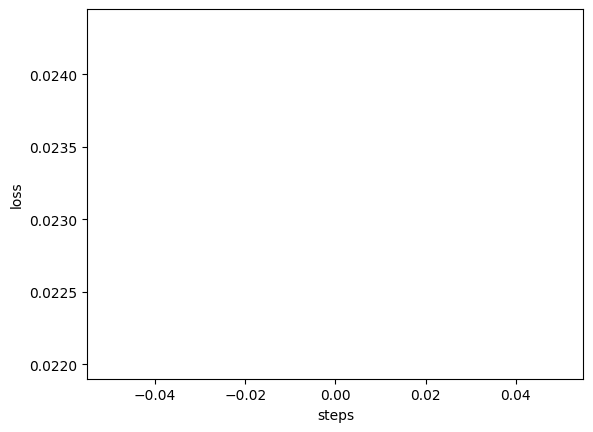

In [13]:
# Plot training loss 
plt.plot(loss_error)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [15]:
# gets test loss using both criterion

num_correct = 0
num_samples = len(test_dataset)

model.eval()
loss = 0
with torch.no_grad():
    inp, out_true = next(iter(test_dataloader))
    out = model(inp)
    loss1 = criterion1(out, out_true)

print(f"Average test loss (mse): {loss1 / num_samples}")

Average test loss (mse): 0.00022657870431430638


In [16]:
import pickle 

with torch.no_grad():
    inp, out_true = next(iter(whole_dataloader))
    out = model(inp)

with open('model_outputs/using_dataloader_test.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)